V tomto cvičení zkus naimplementovat klasifikátor, který rozpozná pozitivní recenzi produktu od negativní. Takové úloze se občas říká sentiment analysis.

Pracuj se souborem reviews.csv. Soubor obsahuje text recenze, a výstupní proměnnou label se dvěma hodnotami, neg a pos. Můžeš si všimnout, že data už nějakým čištěním prošla. Porovnej alespoň dva algoritmy. Jaké je nejlepší f1-score, kterého jsi dosáhl/a?

In [238]:
import requests
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import TSNE
from sklearn.svm import LinearSVC
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
    accuracy_score,
)

In [130]:
r = requests.get("https://raw.githubusercontent.com/lutydlitatova/czechitas-datasets/main/datasets/reviews.csv")
open("reviews.csv", "wb").write(r.content)

4617570

In [131]:
reviews_df = pd.read_csv("reviews.csv")
reviews_df

,label,product,review
0,neg,music,the cd came as promised and in the condition p...
1,neg,dvd,this was a very annoying and boring flick that...
2,neg,health,the braun ls-5550 silk&soft bodyshave recharge...
3,pos,camera,"when it comes to buying camcorders , i persona..."
4,neg,dvd,i had high hopes for this series when i starte...
...,...,...,...
5995,neg,health,"i like the idea , but the slippers just are n'..."
5996,pos,health,i eat one of these twice a week before i play ...
5997,pos,music,i get the sense that the fleetwoods'body of re...
5998,neg,dvd,"if i 'm not mistaken , the only difference bet..."


In [132]:
X = reviews_df["review"]
y = reviews_df["label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)

<AxesSubplot:>

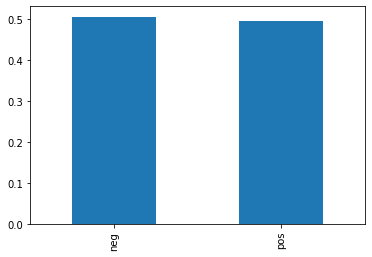

In [133]:
y_train.value_counts(normalize=True).plot(kind="bar")

In [134]:
pipeline = Pipeline(
    [
        ("vec", CountVectorizer(stop_words="english")),
        ("clf", KNeighborsClassifier(n_neighbors=40)),
    ]
)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

f"accuracy: {round(accuracy_score(y_test, y_pred), 2)}", f"f1 score: {round(f1_score(y_test, y_pred, average='weighted'), 2)}"

('accuracy: 0.53', 'f1 score: 0.43')

In [135]:
confusion_matrix(y_test, y_pred)

array([[ 84, 674],
       [ 28, 714]])

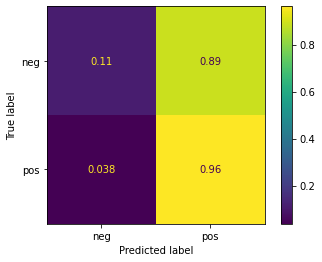

In [136]:
ConfusionMatrixDisplay.from_estimator(pipeline, X_test, y_test, normalize="true")

In [179]:
pipeline = Pipeline(
    [
        ("vec", TfidfVectorizer(stop_words="english", ngram_range=(1,2))),
        ("clf", LinearSVC(random_state=0)),
    ]
)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

f"accuracy: {round(accuracy_score(y_test, y_pred), 2)}", f"f1 score: {round(f1_score(y_test, y_pred, average='weighted'), 2)}"

('accuracy: 0.8', 'f1 score: 0.8')

In [138]:
confusion_matrix(y_test, y_pred)

array([[613, 145],
       [152, 590]])

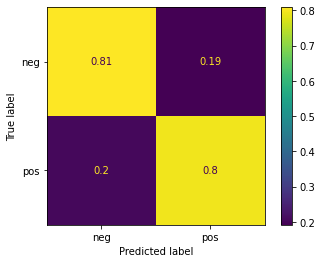

In [139]:
ConfusionMatrixDisplay.from_estimator(pipeline, X_test, y_test, normalize="true")

# Dobrovolný doplněk

Identifikuj ty recenze, které tvůj model označil špatně. Na pár z nich se podívej, a zkus odvodit, proč model chyboval.

In [140]:
df = pd.DataFrame({"text": X_test, "true": y_test, "pred": y_pred}).reset_index(drop=True)
misclassfield = df[df["true"] != df["pred"]]
misclassfield = misclassfield.style.set_properties(subset=['text'], **{'width-min': '1500px'})
misclassfield

,text,true,pred
9,"travolta was great in saturday night fever , but this country version just did n't work . although he 's a good actor , he just was wrongly cast in this film",neg,pos
12,"i was 5 minutes early getting out of the house to go to work one morning so i decided i could stop by a coffee shop and get a mocha . on my way back to my car the mocha "" splooshed "" out of the sipping hole in the to-go lid and got all over my sweater...naturally , that day it was a white silk knit sweater . so i had these large dark brown coffee / chocolate stains , and a decision to make about whether to make myself extremely late to work by going home to change . the cafe was next to a supermarket so i decided to go buy a tide to go pen and give it a try . i applied it as directed to the stain and immediately the stain lightened noticeably . i was a bit worried because after treatment there were still light tan stains visible , but after blotting the excess liquid and letting the sweater dry while wearing for about half an hour , there was no hint that any mocha had ever touched my sweater . the cleansing agent also gets points for not damaging my silk sweater , despite the fact i was rubbing the product in fairly vigorously ( out of desperation...i was going to be late for work ! ) i 'm not sure how it would work on other stains but i will keep one in my purse from now on . on the packaging it does identify which sorts of stains it works best on , and which it will be less effective on . from other reviews this will not work so well on some common food stains , so that 's why i 'm giving 4 stars and not 5. another minor concern is the warning about blotting the fluid if fabric will come into contact with direct sunlight . it does n't say what will happen if you allow saturated fabric to see sunlight . perhaps there is the potential for color / fabric damage",pos,neg
16,"i read this book after watching the brilliant movie version of "" the hours . "" if that 's your motivation , do n't waste your time . my english teachers will cringe when i say it , but this book , well , sucks . it may well be great literature , but the characters are not engaging , and if it was woolf 's motive to out-do james joyce in chronicling a day-in-the-life and in writing a stream of conscious narrative , she does n't pull it off . again , the characters and the internal mental life simply do n't have the power that "" ulysses "" has . reading woolf is necessary for a good eduction . i recommend , however , that you read "" to the lighthouse "" . i may still be motivated to read the book version of "" the hours "" given how great the movie was . but my taste for woolf is all done now .",neg,pos
19,"this cd has alot of tight hits including : nann by trick daddy and who dat ' by j.t. money . there are too many good songs to name for this cd , those are the biggest i like and i like all the others too . i can practically just listen to the whole cd without stopping it , which usually never happens with other cd 's b / c u buy it for about 3 good songs and all the other songs are junk . but this cd has all the hip hop hits that it proclaims . i suggest anyone looking at this review or cd , to buy the cd . it 's worth it , definetely ! one last word is that you will have no regrets buying this cd at all i think in my own opinion.i am from st. louie and i am telling ya 'll to look out for a new group called nelly also , there hit single is already out & quot ; country grammar"" ; and cd soon to be out . get that when it comes out to . peace out ya 'll",pos,neg
24,"i loved the core knowledge curriculum . the reason i switched my children to a charter school is that they started out teaching ck . i also switched them back to the public school when the principal got away from ck and made it just like a public school . i agree that a teacher should supplement what is in the ck books to give their students a better understanding of the material . teaching the informati

Odhad důvodů chybovosti: sarkasmus se z písma nepozná, výjimečně dlouhý nebo výjimečně krátký text, překlepy, jiný jazyk než angličtina, hovorové výrazy, které jsou v jiných recenzích zastoupeny obecnějšími (rozšířenějšími) slovy

# Dobrovolný doplněk 2

Všimni si, že soubor obsahuje také sloupec product, který identifikuje kategorii produktu.

Mohlo by být zajímavé se podívat, jestli je možné data do těchto kategorií shlukovat bez využití této informace.

In [198]:
X = pd.read_csv("reviews.csv")
X.head()

,label,product,review
0,neg,music,the cd came as promised and in the condition p...
1,neg,dvd,this was a very annoying and boring flick that...
2,neg,health,the braun ls-5550 silk&soft bodyshave recharge...
3,pos,camera,"when it comes to buying camcorders , i persona..."
4,neg,dvd,i had high hopes for this series when i starte...


Data normalizuj (například pomocí TfidfVectorizer), a zkus spustit nějaký shlukovací algoritmus, například KMeans.

In [199]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(X["review"])
vectorizer.get_feature_names_out()

array(['00', '000', '0003', ..., 'áron', 'árpád', 'énnui'], dtype=object)

In [233]:
tsne = TSNE(
    init="pca",
    n_components=2,
    perplexity=30,
    learning_rate="auto",
    random_state=0,
)

X = tsne.fit_transform(X)
X.shape

/Users/hedvikapajerova/venv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


(6000, 2)

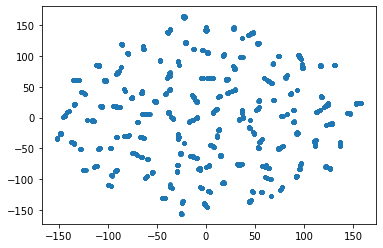

In [234]:
plt.scatter(X[:, 0], X[:, 1], s=10)

In [235]:
model = KMeans(n_clusters=6, random_state=0)
labels = model.fit_predict(X)

Výsledky shlukování můžeš "obarvit" správnými kategoriemi.

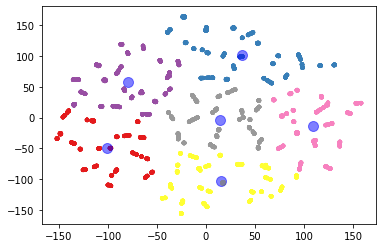

In [236]:
plt.scatter(X[:, 0], X[:, 1], c=labels, s=10, cmap="Set1")
centers = model.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c="blue", s=100, alpha=0.5)

Povedlo se modelu predikovat kategorie?

In [245]:
y = pd.read_csv("reviews.csv")
y = y["product"]
y

0        music
1          dvd
2       health
3       camera
4          dvd
         ...  
5995    health
5996    health
5997     music
5998       dvd
5999    camera
Name: product, Length: 6000, dtype: object

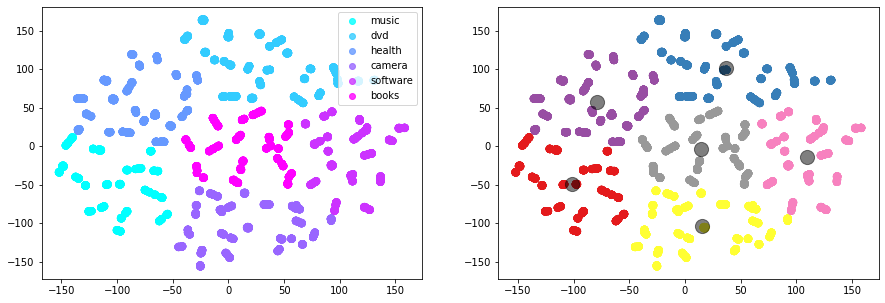

In [247]:
plt.figure(figsize=(15, 5))

# sp1
plt.subplot(121)
scatter = plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap="cool", alpha=0.8)
centers = model.cluster_centers_
plt.legend(handles=scatter.legend_elements()[0], labels=list(y.unique()))

# sp2
plt.subplot(122)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap="Set1")
centers = model.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c="black", s=200, alpha=0.5)

Vyzkoušej také klasifikaci do těchto kategorií.

In [249]:
X = reviews_df["review"]
y = reviews_df["product"]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)

<AxesSubplot:>

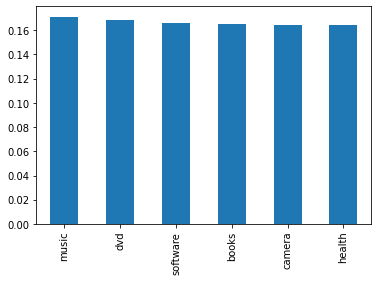

In [251]:
y_train.value_counts(normalize=True).plot(kind="bar")

In [254]:
pipeline = Pipeline(
    [
        ("vec", TfidfVectorizer(stop_words="english", ngram_range=(1,1))),
        ("clf", LinearSVC(random_state=0)),
    ]
)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
f"accuracy: {round(accuracy_score(y_test, y_pred), 2)}", f"f1 score: {round(f1_score(y_test, y_pred, average='weighted'), 2)}"

('accuracy: 0.93', 'f1 score: 0.93')

Které kategorie se těžko odlišují?

In [255]:
confusion_matrix(y_test, y_pred)

array([[232,   0,   7,   2,   4,   3],
       [  0, 222,   2,  15,   2,   6],
       [  6,   0, 233,   2,  11,   1],
       [  4,   5,   1, 229,   1,   7],
       [  2,   0,   4,   2, 246,   3],
       [  1,   4,   5,   5,   5, 228]])

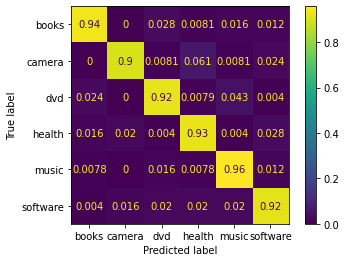

In [256]:
ConfusionMatrixDisplay.from_estimator(pipeline, X_test, y_test, normalize="true")

Nejhůře se odlišuje dvd od music, camera od software a book od dvd.